<a href="https://colab.research.google.com/github/albertomariapepe/Learning-Rotations/blob/main/LearningRotations_6D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/pygae/clifford.git@master

In [ ]:
!pip install tensorflow_graphics

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 35,465
Trainable params: 35,465
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
367/367 [==============================] - 2s 4ms/step - loss: 0.2962 - val_loss: 0.2941
Epoch 2/100
367/367 [==============================] - 1s 4ms/step - loss: 0.2941 - val_loss: 0.2941
Epoch 3/100
367/367 [==============================] - 1s 4ms/step - loss: 0.2941 - val_loss: 0.2941
Epoch 4/100
367/367 [==============================] - 1s 4ms/step - loss: 0.2941 - val_loss: 0.2941
Epoch 5/100
367/367 [==============================] - 1s 4ms/step - loss: 0.2941 - val_loss: 0.2941
Epoch 6/100
367/367 [==============================] - 1s 4ms/step - loss: 0.2941 - val_loss: 0.2941
Epoch 7/100
367/367 [==============================] - 1s 4ms/step - loss: 0.2941 - val_loss: 0.2941
Epoch 8

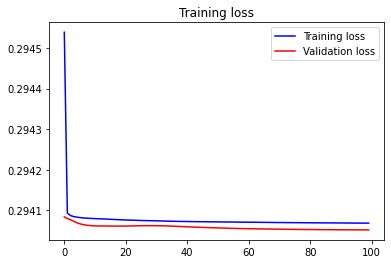

2.060459503028294
0.7927917438120422
0.3174977705307476


In [ ]:
from scipy.spatial.transform import Rotation as R
import numpy as np
from clifford.g3c import *
from clifford.tools.g3c import *
from clifford.tools.g3c.rotor_parameterisation import *
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout
from keras import backend as K
from sklearn.model_selection import train_test_split
from math import acos
import tensorflow as tf
from matplotlib import pyplot as plt
import keras
from math import e, pi
import tensorflow_graphics as tfg
import tensorflow_graphics.geometry.transformation as tfg_transformation

#THESE TWO ARE REQUIRED TO CONVERT TENSOR TO NUMPY ARRAY
#tf.compat.v1.enable_eager_execution()
#tf.config.run_functions_eagerly(True)

#GENERATING THE RANDOM DATASET
tot = int(1e5)
i = 0

r = np.load('R.npy')
r = np.reshape(r, [tot, 3, 3])  

'''
n = []
for i in range(0,tot):
    a1 = r[i,:,0]
    a2 = r[i,:,1]

    b1 = a1 / np.linalg.norm(a1)
    b2 = a2 - np.dot(a1,b1)*b1
    b2 = b2 / np.linalg.norm(b2)

    b3 = np.cross(b1, b2)
    #B1 = b1[0]*e1 + b1[1]*e2 + b1[2]*e3
    #B2 = b2[0]*e1 + b2[1]*e2 + b2[2]*e3

    #B3 = B1 ^ B2
    #b3 = [B3[6], B3[7], B3[10]]
    #b3 = b3/np.linalg.norm(b3)

    n = np.append(n, np.transpose([b1, b2, b3]))
    #n = np.append(n, np.transpose([b3]))

'''
r = np.reshape(r, [tot, 9])    

#Train - Test Split
r_train, r_test = train_test_split(r, test_size=0.33, shuffle=True)
#n_train, n_test = train_test_split(n, test_size=0.33, shuffle=False)

TRAIN = r_train
TEST = r_test
out_size = 9

nb_epoch = 100
batch_size = 128

r_input = Input(shape=(9))
x = Dense(128)(r_input)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(128)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(128)(x)
x = LeakyReLU(alpha=0.2)(x)
out = Dense(out_size)(x)
#out = LeakyReLU(alpha=0.2)(out)


tf.executing_eagerly()


def custom_loss(y_true, y_pred):

    y_pred = tf.reshape(y_pred, [-1, 3, 3])
  
    a1 = y_pred[:,:,0]
    a2 = y_pred[:,:,1]


    b1, _ = tf.linalg.normalize(a1, ord='euclidean')
    c = tf.tensordot(b1, a2, axes=[1, 1])
    c = a2 - tf.matmul(c, b1)
    b2, _ = tf.linalg.normalize(c, ord='euclidean')

    b3 = tf.linalg.cross(b1, b2)
    y_pred_rot = tf.concat([b1, b2, b3], axis = 1)

    l2 = K.mean((y_true - y_pred_rot)**2)

    return l2

model = keras.Model(r_input,  out)
model.summary()
#opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=False)
model.compile(loss=custom_loss, optimizer='adam')
#es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
model_train = model.fit(x = r_train, y = r_train,
                        validation_split=0.3,
                        epochs=nb_epoch,
                        shuffle = False,
                        verbose=1,
                        batch_size=batch_size)



loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(nb_epoch)
plt.figure()
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

predicted = model.predict(r_test)

M = []
Langle = []

for i in range(0,int(tot*0.33)):
    y_pred = np.reshape(predicted[i], [3, 3])

    a1 = y_pred[:,0]
    a2 = y_pred[:,1]

    b1 = a1 / np.linalg.norm(a1)
    b2 = a2 - np.dot(a2,b1)*b1
    b2 = b2 / np.linalg.norm(b2)

    b3 = np.cross(b1, b2)

    y_pred = np.transpose([b1, b2, b3])
    y_pred = np.reshape([b1, b2, b3], [3,3])
    y_real = np.reshape(r_test[i], [3, 3])

    

    M = np.matmul(y_real, np.linalg.inv(y_pred))
    cosine = (M[0,0] + M[1,1] + M[2,2] - 1)/2

    #M = np.dot(y_real,  1/y_pred)
    #cosine = (M - 1)/2
    if cosine > 1:
        cosine = 1
    
    if cosine < -1:
        cosine = -1
    
    #print(acos(cosine))
    Langle = np.append(Langle, acos(cosine))



print(np.max(Langle)*180/pi)
print(np.average(Langle)*180/pi)
print(np.std(Langle)*180/pi)

#np.save('B_loss.npy', loss)
np.save('sanity_6D_val_loss.npy', val_loss)
#np.save('B_langle.npy', Langle)


In [ ]:
predicted = model.predict(r_test)
TEST = r_test

Langle = []
for i in range(0,int(tot*0.33)):
    y_pred = np.reshape(predicted[i], [3, 3])

    a1 = y_pred[:,0]
    a2 = y_pred[:,1]

    b1 = a1 / np.linalg.norm(a1)
    b2 = a2 - np.dot(a2,b1)*b1
    b2 = b2 / np.linalg.norm(b2)

    b3 = np.cross(b1, b2)

    #y_pred = np.transpose([b1, b2, b3])
    y_pred_n = np.reshape([b1, b2, b3], [3,3])
    y_real = np.reshape(TEST[i], [3, 3])

    
    M = np.matmul(y_real, np.linalg.inv(y_pred_n))
    cosine = (M[0,0] + M[1,1] + M[2,2] - 1)/2

    #M = np.dot(y_real,  1/y_pred)
    #cosine = (M - 1)/2
    if cosine > 1:
        cosine = 1
    
    if cosine < -1:
        cosine = -1
    
    if i < 4:
        #print(predicted[i])
        #print(y_pred)
        #print('---')
        #print(y_pred_n)
        #print(y_pred_n)
        print('---')
        #print(y_real)
        print(M)
        print('-----------')
    
    #print(acos(cosine))
    Langle = np.append(Langle, acos(cosine))



print(np.max(Langle)*180/pi)
print(np.average(Langle)*180/pi)
print(np.std(Langle)*180/pi)

---
[[ 0.99983226  0.01443583  0.01127558]
 [-0.0144542   0.99989435  0.00155153]
 [-0.01125197 -0.00171427  0.99993531]]
-----------
---
[[ 0.99987199  0.01565603  0.00330194]
 [-0.01572561  0.99962996  0.02219729]
 [-0.00295317 -0.02224639  0.99974822]]
-----------
---
[[ 0.99990812 -0.00770133  0.01115709]
 [ 0.00812657  0.99922228 -0.03858389]
 [-0.01085126  0.03867102  0.99919306]]
-----------
---
[[ 0.99993698  0.00863511  0.00717411]
 [-0.00867239  0.99994902  0.00518099]
 [-0.007129   -0.00524287  0.99996087]]
-----------
2.5361841029956356
1.0596096645778739
0.41207780758465157


In [ ]:
Q = R.random(random_state = i).as_quat()
print(Q)
Rot = Q[0] + Q[1]*e13 +Q[2]*e23 + Q[3]*e12
B = -2*general_logarithm(Rot)

print(B)
print('----')
Q = - Q
print(Q)
Rot = Q[0] + Q[1]*e13 +Q[2]*e23 + Q[3]*e12
B = -2*general_logarithm(Rot)
print(B)

In [ ]:
!zip -r /content/ /content

from google.colab import files
files.download("/content/.zip")